In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [3]:
### Load supervoxel labels ###
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/labels.pickle'
with open(labels_file, 'rb') as handle:
    cluster_model_labels = pickle.load(handle)

In [4]:
### Load PCs ###
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_vectors_ztrim.npy'
vectors = np.load(file).real
print(f'vectors are {vectors.shape} voxel by PC')

vectors are (26840, 26840) voxel by PC


In [5]:
### Flip Sign ###
vectors = vectors*-1

In [6]:
running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(vectors[running_sum:num_clusters+running_sum,:])
    running_sum += num_clusters

In [7]:
pc = 0

pc_vol = []
for i, z in enumerate(range(9,49-9)):
    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
        cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
    colored_by_betas = colored_by_betas.reshape(256,128)
    pc_vol.append(colored_by_betas)

In [8]:
pc_vol = np.asarray(pc_vol)
pad = np.zeros((9,256,128))
pc_vol_full = np.concatenate((pad,pc_vol,pad))
pc_vol_full = np.moveaxis(pc_vol_full,0,2)
pc_vol_full.shape

(256, 128, 49)

In [9]:
moving = ants.from_numpy(pc_vol_full[:,:,::-1])
moving.set_spacing((2.6076, 2.6154, 5.3125)) ### matching this to the slightly off luke mean

In [10]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [11]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])

In [12]:
pca_map = maps_voxel_res.numpy()

In [13]:
pca_map = pca_map*-1

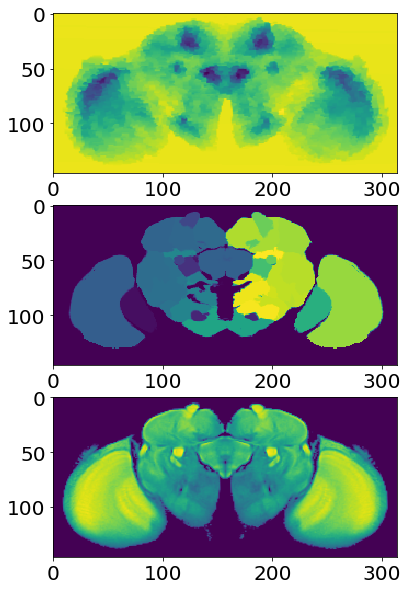

In [14]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(pca_map[:,:,z].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

(-0.5, 313.5, 145.5, -0.5)

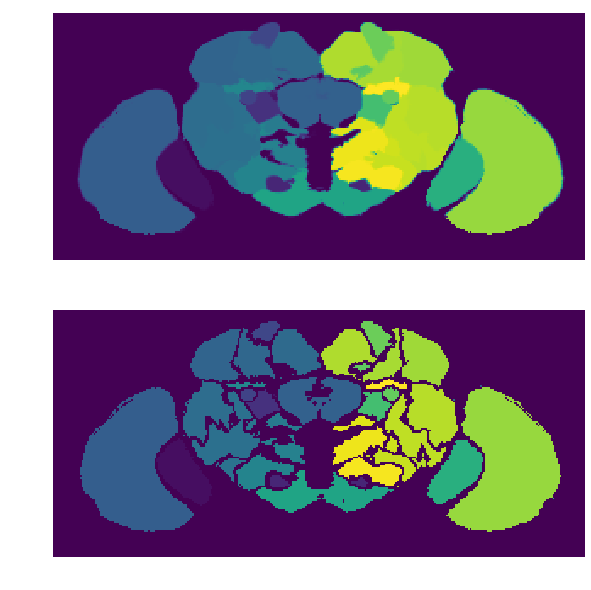

In [15]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [16]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # CORR
        #masked_roi = mask_dilated[...,np.newaxis]*corr_map #CORR
        #masked_roi_flat = np.max(masked_roi,axis=2)
        #roi_data.append(masked_roi_flat)

        #PCA
        masked_roi = mask_dilated*pca_map
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        masked_roi_flat = maxs
        roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    # CORR
    #roi_datas = np.max(np.asarray(roi_data),axis=0)
    #data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*20
    
    #PCA
#     roi_datas = np.max(np.asarray(roi_data),axis=0)
#     data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    roi_data = np.asarray(roi_data)
    maxs = np.max(roi_data,axis=0)
    mins = np.min(roi_data,axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [17]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

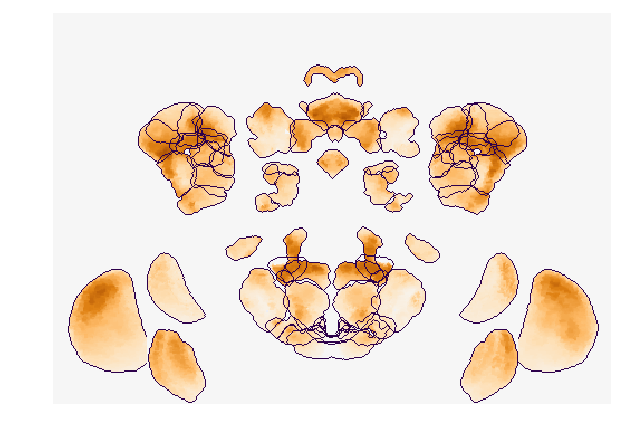

In [18]:
#input_canvas = np.zeros((500,500,3))
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
plt.figure(figsize=(10,10))
#plt.imshow(canvas)
plt.imshow(canvas[150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
#plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

##### Some mesh outputting

In [30]:
from skimage import measure

In [22]:
pca_map = pca_map*-1

In [19]:
pca_map.shape

(314, 146, 91)

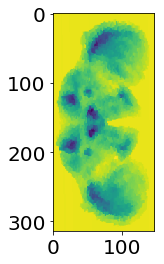

In [20]:
plt.imshow(pca_map[:,:,50])

In [34]:
out = np.where(pca_map>.005)
out = np.asarray(out)

In [35]:
empty = np.zeros(pca_map.shape)
empty[out[0,:], out[1,:], out[2,:]] = 1

In [36]:
empty = np.moveaxis(empty,0,2)
empty = np.swapaxes(empty,0,2)
empty = empty[:,:,::-1]
empty.shape

(314, 91, 146)

In [37]:
mask_eroded = binary_erosion(empty, structure=np.ones((5,5,5)))
mask_dilated = binary_dilation(mask_eroded, iterations=5)

In [38]:
verts, faces, normals, values = measure.marching_cubes_lewiner(mask_dilated, 0.5, step_size=2) #.5

In [39]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210818_3d_pickles/verts_20220118_pc.pickle'
with open(save_file, 'wb') as f:
    pickle.dump(verts, f)
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210818_3d_pickles/faces_20220118_pc.pickle'
with open(save_file, 'wb') as f:
    pickle.dump(faces, f)

(array([19171.,  7549.,  8405.,  5068.,  2787.,  1161.,   758.,   558.,
          311.,    76.]),
 array([-0.00053498,  0.00140762,  0.00335022,  0.00529283,  0.00723543,
         0.00917803,  0.01112064,  0.01306324,  0.01500584,  0.01694844,
         0.01889105]),
 <a list of 10 Patch objects>)

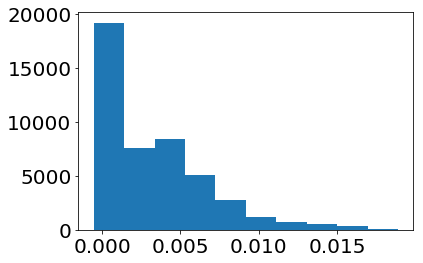

In [23]:
plt.hist(pca_map[:,:,50].flatten())

In [19]:
def grab_pc_map(pc):
    pc_vol = []
    for i, z in enumerate(range(9,49-9)):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
        colored_by_betas = colored_by_betas.reshape(256,128)
        pc_vol.append(colored_by_betas)
    pc_vol = np.asarray(pc_vol)
    pad = np.zeros((9,256,128))
    pc_vol_full = np.concatenate((pad,pc_vol,pad))
    pc_vol_full = np.moveaxis(pc_vol_full,0,2)
    pc_vol_full.shape
    
    moving = ants.from_numpy(pc_vol_full[:,:,::-1])
    moving.set_spacing((2.6076, 2.6154, 5.3125)) ### matching this to the slightly off luke mean
    
    out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
    maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0])
    pca_map = maps_voxel_res.numpy()
    pca_map = pca_map*-1
    return pca_map

In [35]:
def explode_pc_map():
    input_canvas = np.zeros((500,500)) #pca
    canvas = None

    x_shift=0; y_shift=0
    data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=-45
    data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=35
    data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##########
    ### MB ###
    ##########

    # x_shift=60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    # x_shift=-60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    #################
    ### BIG GROUP ###
    #################

    x_shift=-130; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=130; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##############
    ### VISUAL ###
    ##############

    x_shift=-200; y_shift=175
    data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=200; y_shift=175
    data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-140; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=140; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-140; y_shift=-30+175
    data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=140; y_shift=-30+175
    data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-50; y_shift=55
    data_map, contours = plot_grouped_roi_image(ventromedial_r_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    
    x_shift=50; y_shift=55
    data_map, contours = plot_grouped_roi_image(ventromedial_l_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    
    x_shift=0; y_shift=150
    data_map, contours = plot_grouped_roi_image(anterior_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-80; y_shift=-50+175-15
    data_map, contours = plot_grouped_roi_image({34: 'AOTU_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    
    x_shift=80; y_shift=-50+175-15
    data_map, contours = plot_grouped_roi_image({79: 'AOTU_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    return canvas

In [54]:
#plt.figure(figsize=(10,10))

exploded_pc_maps = []
for pc in range(100):
    print(pc)
    #plt.subplot(1,3,pc+1)
    pca_map = grab_pc_map(pc)    
    canvas = explode_pc_map()
    exploded_pc_maps.append(canvas)
#     plt.imshow(canvas[150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
#     plt.axis('off')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [55]:
fname = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/exploded_pcs.pickle'
with open(fname, 'wb') as handle:
    pickle.dump(exploded_pc_maps, handle, protocol=pickle.HIGHEST_PROTOCOL)

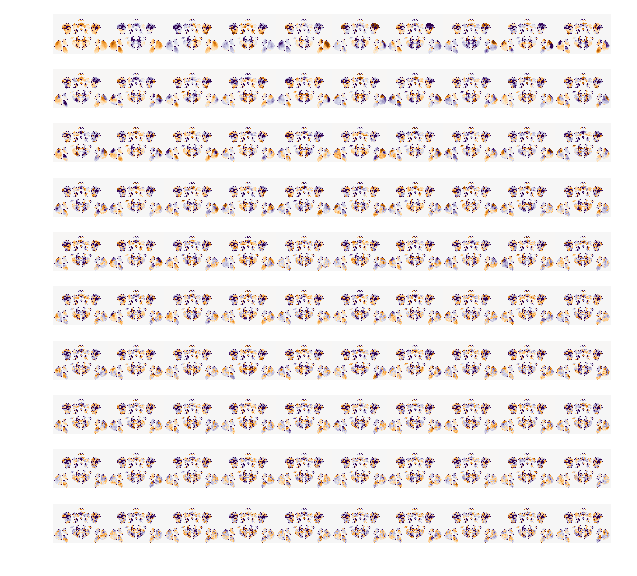

In [60]:
plt.figure(figsize=(10,10))
for pc in range(100):
    plt.subplot(10,10,pc+1)
    plt.imshow(exploded_pc_maps[pc][150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=500,bbox_inches='tight',transparent=True)

# Prep 2D behavior hists

In [37]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal = temporal*-1
temporal.shape #timepoint by PC

(30456, 1000)

In [38]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [39]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)
            
            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1
            
            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)
            
            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [40]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [41]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 80.39 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.45 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 73.16 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.26 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 104.09 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.53 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 93.62 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 7.02 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 82.28 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.44 sec
*** fly: 

In [42]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [43]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    #"PC" is just a holdover
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    #bins_x = np.concatenate((np.linspace(start_x,0,num_bins_x)[:-1], np.linspace(0,end_x,num_bins_x)))
    #bins_y = np.concatenate((np.linspace(start_y,0,num_bins_y)[:-1], np.linspace(0,end_y,num_bins_y)))
    
#     bins_x = [x / 10.0 for x in range(-20, 64, 4)]
#     bins_y = [x / 10.0 for x in range(-40, 44, 4)]
#     num_bins_x = 22
#     num_bins_y = 22
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], bins_x, bins_y

def plot_2D_hist(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = temporal[:,0]
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
       
    if behavior_type in ['velocity', 'velocity_pooled']:
        start_x=-2; end_x=8; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(1.5,linestyle='--',color='k',linewidth=1)
    if behavior_type in ['acceleration', 'acceleration_pooled']:
        start_x=-5; end_x=5; start_y=-5; end_y=5
        ax.axhline(4.5,linestyle='--',color='k',linewidth=1)
        ax.axvline(4.5,linestyle='--',color='k',linewidth=1)
    
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                             num_bins_x=10, num_bins_y=10,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y)
    
    ax.imshow(fictrac_2d,cmap='PuOr',vmin=-1,vmax=1)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
def plot_2D_scatter(fig, fly, behavior_type, x_pos, y_pos):
    ax = fig.add_axes([x_pos,y_pos,.05,.05])

    if behavior_type == 'velocity':
        X_var = flies[fly].fictrac.fictrac['Y']
        Y_var = flies[fly].fictrac.fictrac['Z']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration':
        X_var = flies[fly].fictrac.fictrac['Ya']
        Y_var = flies[fly].fictrac.fictrac['Za']
        signal = flies[fly].cluster_signals[flies[fly].get_cluster_id(x, y), :]
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    if behavior_type == 'velocity_pooled':
        X_var = pooled_behavior['Y']
        Y_var = pooled_behavior['Z']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-2,8)
    if behavior_type == 'acceleration_pooled':
        X_var = pooled_behavior['Ya']
        Y_var = pooled_behavior['Za']
        signal = pooled_activity
        ax.set_ylim(-5,5)
        ax.set_xlim(-5,5)
    
    ax.scatter(x=X_var,
               y=Y_var,
               c=signal,
               marker='x',cmap='PuOr',vmin=-1,vmax=1,s=.5,linewidth=.1) #s,.2,lw=0
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.axhline(0,linestyle='--',color='k',linewidth=1)
    ax.axvline(0,linestyle='--',color='k',linewidth=1)

In [44]:
from matplotlib.colors import ListedColormap

In [45]:
# define top and bottom colormaps 
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

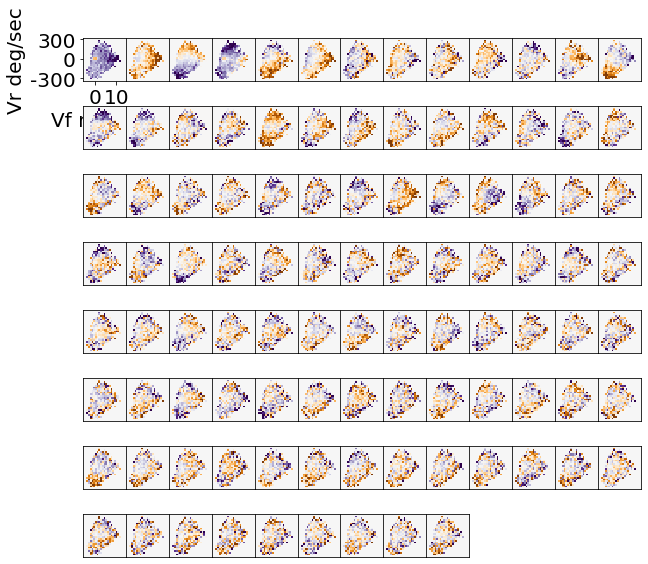

In [50]:
X_var = behavior_super['Y_std']
Y_var = behavior_super['Z_std']
fig = plt.figure(figsize=(10,10))
#ax = fig.add_axes([0,0,1,1])
start_x=-2; end_x=6; start_y=-4; end_y=4

for k in range(100):
    signal = temporal[:,k]
    plt.subplot(8,13,k+1)
    fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                     num_bins_x=25, num_bins_y=25,
                                     start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                     min_num_samples=9)

    fictrac_2d[-1,:] = 0
    #vmax = np.percentile(fictrac_2d,99)
    vmax = np.percentile(np.abs(fictrac_2d),98)
    plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    #plt.imshow(fictrac_2d[:,:],cmap=orange_blue,vmin=-7,vmax=7,extent=[-2.35,6,-4.35,4])

    ax = plt.gca()
    if k == 0:
        
        ratio = np.max(behavior_super['Z_std'])/np.max(behavior_super['Z_units'])
        ax.set_yticklabels([-300, 0, 300])
        ax.set_yticks([-300*ratio, 0, 300*ratio])

        ratio = np.max(behavior_super['Y_std'])/np.max(behavior_super['Y_units'])
        ax.set_xticklabels([0, 10])
        ax.set_xticks([0, 10*ratio])

        plt.ylabel('Vr deg/sec')
        plt.xlabel('Vf mm/sec')
    else:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    #ax.axhline(0,linestyle='--',color='k',linewidth=1)
    #ax.axvline(0,linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(wspace=0, hspace=0)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

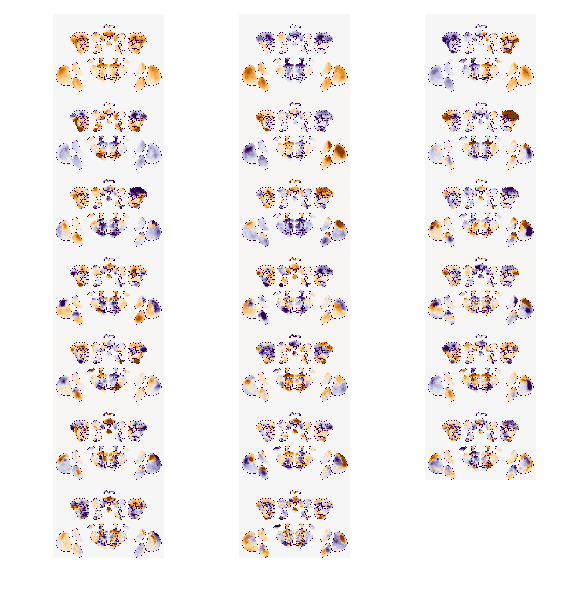

In [64]:
plt.figure(figsize=(10,10))
for pc in range(20):
    plt.subplot(7,3,pc+1)
    plt.imshow(exploded_pc_maps[pc][150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=500,bbox_inches='tight',transparent=True)

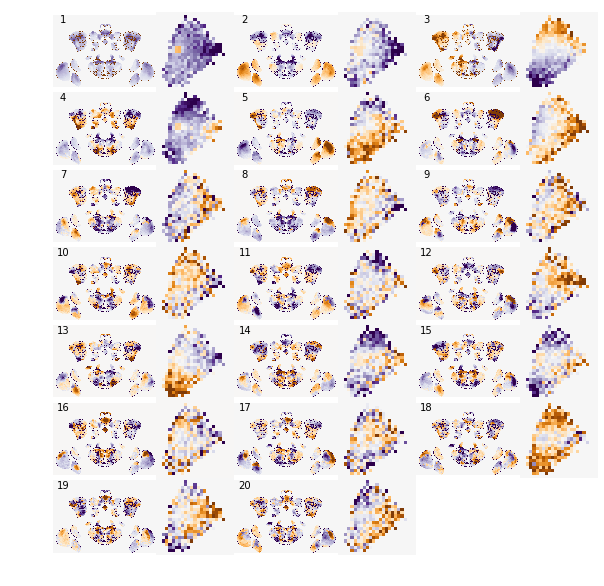

In [99]:
plt.figure(figsize=(10,10))
pc=0
for subplt in range(40):
    plt.subplot(7,6,subplt+1)
    
    if subplt % 2 == 0:
        plt.imshow(exploded_pc_maps[pc][150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
        if pc in [0,2]: #flip sign
            plt.imshow(exploded_pc_maps[pc][150:,:]*-1,cmap='PuOr',vmin=-.025,vmax=.025)

        plt.axis('off')
        plt.title(pc+1,fontsize=10,y=.8,x=.1)
    else:
        signal = temporal[:,pc]
        fictrac_2d, bins_x, bins_y = bin_2D_plot(X_var, Y_var, signal,
                                         num_bins_x=25, num_bins_y=25,
                                         start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                         min_num_samples=9)
        fictrac_2d[-1,:] = 0
        vmax = np.percentile(np.abs(fictrac_2d),98)
        if pc in [1]: #flip sign
            plt.imshow(fictrac_2d[:,:]*-1,cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        else:
            plt.imshow(fictrac_2d[:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        plt.axis('off')
        
        pc+=1

plt.subplots_adjust(wspace=-0.12, hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [22]:
pca_map.shape

(314, 146, 91)

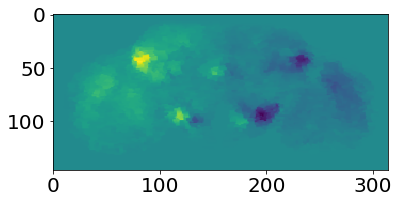

In [27]:
plt.imshow(test[0][:,:,60].T)

In [61]:
from matplotlib.colors import ListedColormap

In [62]:
# define top and bottom colormaps 
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

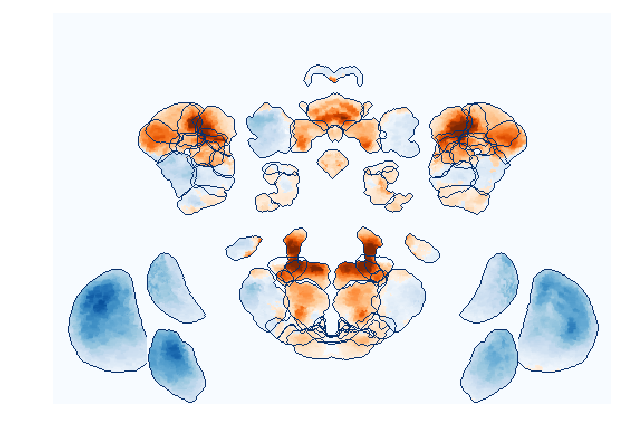

In [66]:
plt.figure(figsize=(10,10))
#plt.imshow(canvas)
plt.imshow(canvas[150:,:],cmap=orange_blue,vmin=-.025,vmax=.025)
#plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_pc_99')
plt.savefig(fname,dpi=300,bbox_inches='tight')

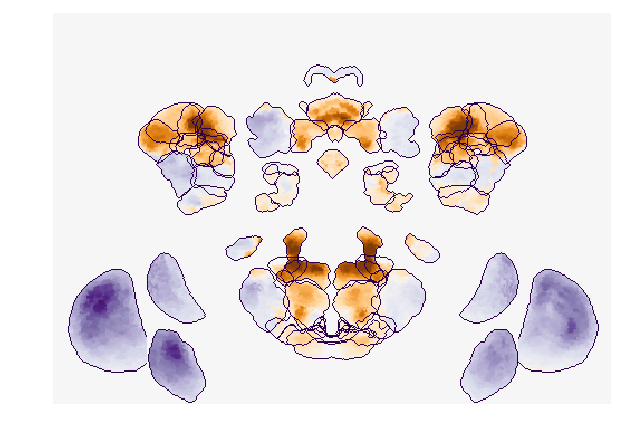

In [65]:
plt.figure(figsize=(10,10))
#plt.imshow(canvas)
plt.imshow(canvas[150:,:],cmap='PuOr',vmin=-.025,vmax=.025)
#plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_pc_99')
plt.savefig(fname,dpi=300,bbox_inches='tight')

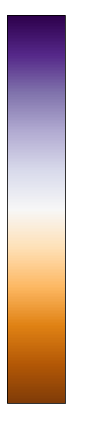

In [81]:
a = np.array([[0,1]])
plt.figure(figsize=(1, 9))
img = plt.imshow(a, cmap="PuOr")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.axis('off')
plt.colorbar(cax=cax)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')